<h1 style="color: #7BB598; text-align: center;"><span style="color: #7BB598;">Canabinoides</span></h1>
<p style="text-align: center;">Coleta e an&aacute;lise dos canabinoides que atuam sobre os receptores CBD1 e CBD2</p>
<p style="text-align: justify;"></p>
<p style="text-align: justify;"></p>

<h1 style="color: #5e9ca0; text-align: left;"><span style="color: #7BB598;">1. Importando bibliotecas</span></h1>

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import os.path

# Estatística
from scipy import stats
from scipy.stats import binom

# Descritores
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

# Acessar base de dados ChemBL
from chembl_webresource_client.new_client import new_client

# Configurando exibição de dados Pandas DataFrame
# Setando max_columns para None, indicando que será exibido todas as colunas
pd.set_option('display.max_columns', None)

<h1 style="color: #7BB598; text-align: left;"><span style="color: #7BB598;">2. Dados</span></h1>

<h2 style="color: #7BB598; text-align: left;"><span style="color: #7BB598;"><strong>2.1. Alvos (targets)</strong></span></h2>
<br><p style="text-align: justify;">Listando especificamente as prote&iacute;nas da esp&eacute;cie <em>Homo sapiens</em> que s&atilde;o alvos de canabinoides (especificando, proteínas simples) . No caso, o retorno ser&aacute;:</p>
<ul>
<li style="text-align: justify;">Receptor canabinoide CB1: localizado principalmente no c&eacute;rebro, em &aacute;reas como hipocampo, hipot&aacute;lamo, vias demarmin&eacute;gicas e na subst&acirc;ncia negra.</li>
<li style="text-align: justify;">Recpetor canabinoide CB2: localizado no ba&ccedil;o, tonsilas, medula &oacute;ssea e c&eacute;lulas do sangue.</li>
</ul>

In [57]:
# Buscando alvos
alvo = new_client.target
consulta_alvo = alvo.search('cannabinoid').filter(organism = 'Homo sapiens').filter(target_type = 'SINGLE PROTEIN')
df_alvos = pd.DataFrame.from_dict(consulta_alvo)
df_alvos

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'P21554', 'xref_name': None, 'xre...",Homo sapiens,Cannabinoid CB1 receptor,15.0,False,CHEMBL218,"[{'accession': 'P21554', 'component_descriptio...",SINGLE PROTEIN,9606
1,"[{'xref_id': 'P34972', 'xref_name': None, 'xre...",Homo sapiens,Cannabinoid CB2 receptor,14.0,False,CHEMBL253,"[{'accession': 'P34972', 'component_descriptio...",SINGLE PROTEIN,9606


<h2 style="color: #7BB598; text-align: left;"><span style="color: #7BB598;"><strong>2.1. Moléculas ('activities')</strong></span></h2>
<p>&nbsp;</p>
<p style="text-align: justify;">Agora, vamos buscar as mol&eacute;culas que tem atividade sobre as prote&iacute;nas CB1 e CB2 do tipo IC50 (compostos que apresentam valores que conseguem inibir at&eacute; 50% da atividade biol&oacute;gica.).&nbsp;</p>

In [58]:
existe = os.path.isfile('atividades.csv')
if existe:
    df_atividades = pd.read_csv('atividades.csv')
else:
    atividade = new_client.activity
    resultado = atividade.filter(target_chembl_id__in	= ['CHEMBL218', 'CHEMBL253']).filter(standard_type='IC50')
    df_atividades = pd.DataFrame.from_dict(resultado)
    
    # Salvando atividades
    df_atividades.to_csv('atividades.csv', index=False, float_format='%.6f', encoding='utf-8')

<h2 style="color: #7BB598; text-align: left;"><span style="color: #7BB598;"><strong>2.2. Standard_value diferente de NaN</strong></span></h2>
<p>&nbsp;</p>

In [59]:
df_atividades2 = df_atividades[df_atividades.standard_value.notna()]

<h2 style="color: #7BB598; text-align: left;"><span style="color: #7BB598;"><strong>2.3. Convertendo tipo da coluna standard_value</strong></span></h2>
<p>&nbsp;</p>

In [60]:
# converte a coluna "standard_value" para o tipo float
df_atividades2 = df_atividades2.astype({"standard_value": float})

<h2 style="color: #7BB598; text-align: left;"><span style="color: #7BB598;"><strong>2.4. Gerando dados de trabalho</strong></span></h2>
<p>&nbsp;</p>

In [61]:
# agrupando dados
df_trabalho = df_atividades2.groupby(['molecule_chembl_id', 
                                      'canonical_smiles'])['standard_value'].max().reset_index(name = 'standard_value')

In [62]:
df_trabalho.head(5)

,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL1076884,O=C(C1CCC1)N1CCN(C(c2ccccc2)c2ccc(Cl)cc2Cl)CC1,10000.0
1,CHEMBL1082305,CC1(C)CC(C(N)=O)c2cc(-c3ccc(Cl)cc3)c(-c3ccc(Cl...,2480.0
2,CHEMBL1082321,CC(C)(CO)NC(=O)C1CC(C)(C)Oc2nc(-c3ccc(Cl)cc3Cl...,7450.0
3,CHEMBL1082330,CN1c2nc(-c3ccc(Cl)cc3Cl)c(-c3ccc(Cl)cc3)cc2C(C...,3390.0
4,CHEMBL1082650,C[C@@H](O)NC(=O)C1CC(C)(C)N(C)c2nc(-c3ccc(Cl)c...,2330.0


<h1 style="text-align: left;"><span style="color: #7BB598;"><strong>3. Descritores Lipinski</strong></span></h1>
<p>&nbsp;</p>
<p style="text-align: justify;">A regra dos cinco de Lipinski diz que uma mol&eacute;cula ser&aacute; considerada um 'bom f&aacute;rmaco', do ponto de vista da permeabilidade e solubilidade, se apresentar as seguintes características:</p>
<ol>
<li style="text-align: justify;">log P menor ou igual a 5</li>
<li style="text-align: justify;">massa molecular menor ou igual a 500</li>
<li style="text-align: justify;">aceptores de liga&ccedil;&atilde;o de hidrog&ecirc;nio menor ou igual a 10</li>
<li style="text-align: justify;">doadores de liga&ccedil;&atilde;o de hidrog&ecirc;nio menor ou igual a 5.</li>
</ol>
<p>&nbsp;</p>

<h2 style="text-align: left;"><span style="color: #7BB598;"><strong>3.1. Gerando descritores</strong></span></h2>

In [63]:
# Array que irá armazenar os descritores
descritores = np.arange(1, 1)

# indica que a primeira entrada
primeiro = True

#  Gerando descritores
for smile in df_trabalho['canonical_smiles']:
    # gerando molécula
    mol = Chem.MolFromSmiles(smile)
    
    # calculando descritores
    descr_MolLogP = Descriptors.MolLogP(mol)
    descr_MolWt = Descriptors.MolWt(mol)
    descr_AcepH = Descriptors.NOCount(mol)
    descr_DoadH = Descriptors.NHOHCount(mol)   
    
    # linha de descritores
    linha = np.array([descr_MolWt, 
                      descr_MolLogP, 
                      descr_AcepH,
                      descr_DoadH])
    
    if primeiro:
        descritores = linha
        primeiro = False
    else:
        descritores = np.vstack([descritores, linha])

# Criando um dataframe para os descritores
colunas = ["massa_molecular", "logp", "aceptores_lig_h", "doadores_lig_h"]
df_descritores = pd.DataFrame(data = descritores, columns = colunas)

<h2 style="text-align: left;"><span style="color: #7BB598;"><strong>3.2. Combinando os dados</strong></span></h2>

In [64]:
existe = os.path.isfile('resultado.csv')
if existe:
    df_resultado = pd.read_csv('resultado.csv')
else:
    df_resultado = pd.concat([df_trabalho, df_descritores], axis = 1)
    df_resultado.head(8)

    # Salvando resultado
    df_resultado.to_csv('resultado.csv', index=False, float_format='%.6f', encoding='utf-8')

In [65]:
df_resultado.shape

(2307, 7)

<h1 style="text-align: left;"><span style="color: #7BB598;"><strong>4. Estatística</strong></span></h1>
<p>&nbsp;</p>

In [66]:
# Excluindo linha cujo valor de massa molecular iria distorcer a média
try:
    df_resultado.drop(index = 920, axis = 0, inplace = True)
except Exception as exc:
    print("Erro: {0}".format(exc))

<h2 style="text-align: left;"><span style="color: #7BB598;"><strong>4.1. Medidas Populacionais</strong></span></h2>

In [67]:
# Array com os valores da massa molecular
massa_atomica = np.array(df_resultado["massa_molecular"])

# Ordena os dados
massa_atomica.sort()

# Mediana
mediana = np.median(massa_atomica)

# Média
media = np.mean(massa_atomica)

# Variância
variancia = np.var(massa_atomica)

# Desvio Padrão
desvio_padrao = np.std(massa_atomica)

print("Estatística Populacional")
print(" + Mediana.......: {0:0.2f}".format(mediana))
print(" + Média.........: {0:0.2f}".format(media))
print(" + Variância.....: {0:0.2f}".format(variancia))
print(" + Desvio padrão.: {0:0.2f}".format(desvio_padrao))

Estatística Populacional
 + Mediana.......: 435.24
 + Média.........: 438.43
 + Variância.....: 6472.86
 + Desvio padrão.: 80.45


<h1 style="text-align: left;"><span style="color: #7BB598;"><strong>5. Tabela de Classes</strong></span></h1>
<p>&nbsp;</p>

<h2 style="text-align: left;"><span style="color: #7BB598;"><strong>5.1. Classes e valores mínimo e máximo</strong></span></h2>

In [68]:
# Número de elementos
n  = df_resultado.shape[0]

# Valores máximo, minimo e sua diferença
vlr_massa_maximo = df_resultado['massa_molecular'].max()
vlr_massa_minimo = df_resultado['massa_molecular'].min()
dif_max_min = vlr_massa_maximo - vlr_massa_minimo

# numero de classes
k = int(np.around((1 + (3.3 * np.log(n))), 0))

# Amplitude das classes
h = np.around((dif_max_min / k), 3)

In [69]:
limites = []
minimo = np.around(vlr_massa_minimo, 3)
for i in range(0, k):
    maximo = np.around((minimo + h), 3)
    
    # ponto médio
    ponto_medio = np.around(((maximo + minimo) / 2), 3)
    
    limites.append([minimo, maximo, ponto_medio])
    
    minimo = maximo

df_classes = pd.DataFrame(limites, columns=['Limite Inferior', 'Limite Superior', 'Ponto Médio'])

<h2 style="text-align: left;"><span style="color: #7BB598;"><strong>5.2. Frequência Absoluta</strong></span></h2>

In [70]:
# Calculando frequências
frequencias = []
for limite in limites:
    qtde = df_resultado[(df_resultado["massa_molecular"] >= limite[0]) & 
                        (df_resultado["massa_molecular"] < limite[1])]['massa_molecular'].count()
    frequencias.append(qtde)

# Adicionando coluna de frequência absoluta
pos_coluna = len(df_classes.columns)
df_classes.insert(pos_coluna, 'Frequência Absoluta', frequencias, True)

# Excluíndo aquelas linhas cuja frequencia é zero, que implica em dizer
# todas as linhas cujo valor máximo é maior que 750,794
#df_classes.drop(df_classes.index[df_classes['Frequência Absoluta'] == 0], inplace = True, axis = 0)

<h2 style="text-align: left;"><span style="color: #7BB598;"><strong>5.3. Frequência Absoluta Relativa</strong></span></h2>

In [71]:
total = sum(frequencias)
freq_abs_rel = []
for freq in frequencias:
    perc = np.around((freq / total), 4)
    freq_abs_rel.append(perc)

pos_coluna = len(df_classes.columns)
df_classes.insert(pos_coluna, 'Frequência Absoluta Relativa', freq_abs_rel, True)

<h2 style="text-align: left;"><span style="color: #7BB598;"><strong>5.4. Frequência Absoluta Acumulada</strong></span></h2>

In [72]:
freq_abs_acumulada = []
acumulado = 0
for freq in frequencias:
    acumulado = acumulado + freq
    freq_abs_acumulada.append(acumulado)

# Adicionando coluna de frequência absoluta acumulada
pos_coluna = len(df_classes.columns)
df_classes.insert(pos_coluna, 'Frequência Absoluta Acumulada', freq_abs_acumulada, True)

In [73]:
# Gerando arquivo csv 
df_classes.to_csv('agrupamento_massa_atomica.csv', encoding='utf-8', index=False, sep=';', decimal=",", float_format='%.3f')

<h2 style="text-align: left;"><span style="color: #7BB598;"><strong>6. Histograma da Massa Molecular</strong></span></h2>

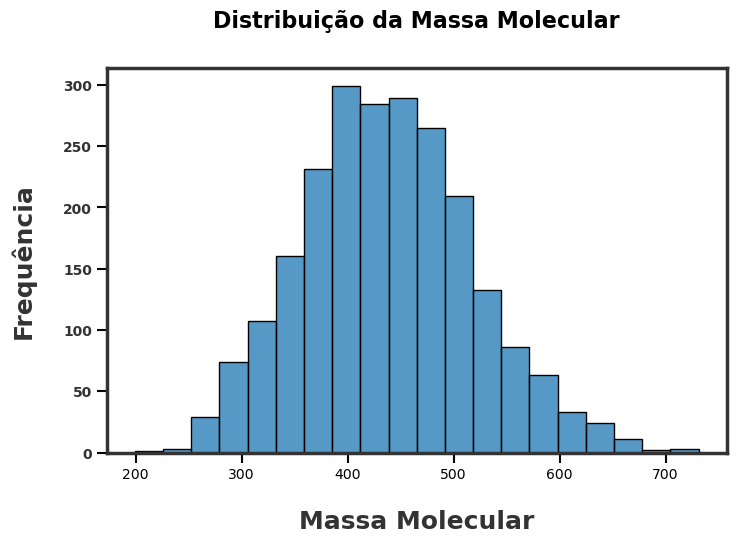

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# Dados
dados = df_resultado

# Histograma
sns.histplot(data = dados, x = 'massa_molecular', 
             linewidth = 1, # tamanho da borda de cada barra do gráfico
             edgecolor = '0', # cor da borda
             kde = False,
             bins = 20)

# Spines -> as linhas dos eixos
for axis in ['bottom', 'left', 'top', 'right']:
    ax.spines[axis].set_linewidth(2.5)
    ax.spines[axis].set_color('0.2')

# Ticks
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Configurando ticks para os valores
# Tick -> linha nos pontos dos eixos
ax.tick_params(which = 'major', length = 7, 
              grid_alpha = 0.5,
              width = 1.5)

# definição geral dos ticks do eixo y
plt.yticks(size = 10, weight = 'bold', color = '0.2')

# Alterando o texto dos eixos
ax.set_xlabel('Massa Molecular', fontsize = 18, 
             weight = 'bold', color = '0.2', labelpad = 20)
ax.set_ylabel('Frequência', 
             fontsize = 18, weight = 'bold', 
             color = '0.2', labelpad = 20)

# Título do gráfico
ax.set_title("Distribuição da Massa Molecular", 
             fontweight = 'bold', 
             fontsize = 16, pad = 29)

# Salvando gráfico
plt.savefig('histograma_massa_molecular.png', bbox_inches = 'tight', dpi =250, facecolor = ax.get_facecolor())

# Exibindo o gráfico
plt.show()

<h2 style="text-align: left;"><span style="color: #7BB598;"><strong>7. Teorema Central do Limite</strong></span></h2>

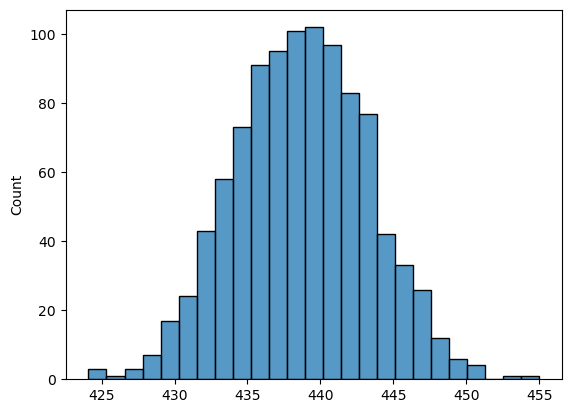

In [75]:
# Array com os valores da massa molecular
massa_atomica = np.array(df_resultado["massa_molecular"])

# Tamanho dos dados
n = df_resultado.shape[0]

# Tamanho da amostra
tam_amostra = 300

# Número de amostras
num_amostras = 1000

amostras = np.empty(shape=[0, tam_amostra])

for i in range(0, num_amostras):
    amostra = []
    for j in range(0, tam_amostra):
        posicao = np.random.randint(0, n)
        amostra.append(massa_atomica[posicao])
    amostras = np.append(amostras, [amostra], axis=0)
    
# Médias amostrais
medias_amostrais = []
for amostra in amostras:
    medias_amostrais.append( np.around( np.mean(amostra), 2))

sns.histplot(x = medias_amostrais)
plt.show()

<h2 style="text-align: left;"><span style="color: #7BB598;"><strong>8. Intervalo de Confiança (para a média populacional)</strong></span></h2>

<h2 style="text-align: left;"><span style="color: #7BB598;"><strong>8.1. Amostra com 50 itens</strong></span></h2>

In [76]:
# Tamanho dos dados
n = df_resultado.shape[0]

# Array com os valores da massa molecular
massa_molecular = np.array(df_resultado["massa_molecular"])

# Tamanho da amostra a ser coletada
n_IC = 50

# Amostra
amostra_IC = []

for j in range(0, tam_amostra):
    posicao = np.random.randint(0, n)
    amostra_IC.append(massa_molecular[posicao])


df_amostra50itens = pd.DataFrame(
    amostra_IC, 
    columns = ['Massa Molecular']
)

# Salvando tabela no formato excel
df_amostra50itens.to_excel('amostra50itens.xlsx', 
             index=True, header=True, index_label = 'Índice', 
             sheet_name = 'amostra50itens', 
             float_format="%.4f")


<h3 style="text-align: left;"><span style="color: #7BB598;"><strong>8.1.1. Média, variância e desvio padrão da amostra</strong></span></h3>

In [77]:
media_amostra_IC = np.mean(amostra_IC)
desvio_padrao_amostra_IC = np.std(amostra_IC)
variancia_amostra_IC = np.var(amostra_IC)
print("Média dos valores de massa atômica da amostra: {0:0.3f}".format(media_amostra_IC))
print("Variância da amostra.........................: {0:0.3f}".format(variancia_amostra_IC))
print("Desvio Padrão da amostra.....................: {0:0.3f}".format(desvio_padrao_amostra_IC))


Média dos valores de massa atômica da amostra: 432.186
Variância da amostra.........................: 5296.612
Desvio Padrão da amostra.....................: 72.778


<h3 style="text-align: left;"><span style="color: #7BB598;"><strong>8.1.2. Intervalo de Confiança</strong></span></h3>

In [78]:
nivel_confianca = 0.95
grau_liberdade = n_IC - 1
alfa = 1 - nivel_confianca
alfa_sobre_dois = np.around((alfa / 2), 5)
valor_t = 2.009
erro = np.around( (valor_t * ((desvio_padrao_amostra_IC) / np.sqrt(n_IC))), 2)

In [79]:
print("Nível de confiança.: {0:0.2f}%".format(nivel_confianca*100))
print("Grau de liberdade..: {0}".format(grau_liberdade))
print("Alfa (\u0251)...........: {0:0.2f}".format(alfa))
print("Alfa sobre 2.......: {0:0.3f}".format(alfa_sobre_dois))
print("Valor t............: {0:0.2f}".format(valor_t))
print("Erro...............: {0:0.2f}".format(erro))
print("")
print("P({0} \u2264 \u03BC \u2264 {1}) = {2}%".format(np.around((media_amostra_IC - erro), 2), 
                                             np.around((media_amostra_IC + erro), 2), 
                                             (nivel_confianca*100)))

Nível de confiança.: 95.00%
Grau de liberdade..: 49
Alfa (ɑ)...........: 0.05
Alfa sobre 2.......: 0.025
Valor t............: 2.01
Erro...............: 20.68

P(411.51 ≤ μ ≤ 452.87) = 95.0%


<h2 style="text-align: left;"><span style="color: #7BB598;"><strong>8.2. Coletando amostra com 100 itens</strong></span></h2>

In [80]:
# Tamanho dos dados
n = df_resultado.shape[0]

# Array com os valores da massa molecular
massa_molecular = np.array(df_resultado["massa_molecular"])

# Tamanho da amostra a ser coletada
n_IC = 100

# Amostra
amostra_IC = []

for j in range(0, tam_amostra):
    posicao = np.random.randint(0, n)
    amostra_IC.append(massa_molecular[posicao])

df_amostra100itens = pd.DataFrame(
    amostra_IC, 
    columns = ['Massa Molecular']
)

# Salvando tabela no formato excel
df_amostra100itens.to_excel('amostra100itens.xlsx', 
             index=True, header=True, index_label = 'Índice', 
             sheet_name = 'amostra100itens', 
             float_format="%.4f")

<h3 style="text-align: left;"><span style="color: #7BB598;"><strong>8.2.1. Média, variância e desvio padrão da amostra</strong></span></h3>

In [81]:
media_amostra_IC = np.mean(amostra_IC)
desvio_padrao_amostra_IC = np.std(amostra_IC)
variancia_amostra_IC = np.var(amostra_IC)
print("Média dos valores de massa atômica da amostra: {0:0.3f}".format(media_amostra_IC))
print("Variância da amostra.........................: {0:0.3f}".format(variancia_amostra_IC))
print("Desvio Padrão da amostra.....................: {0:0.3f}".format(desvio_padrao_amostra_IC))


Média dos valores de massa atômica da amostra: 434.297
Variância da amostra.........................: 7668.052
Desvio Padrão da amostra.....................: 87.567


<h3 style="text-align: left;"><span style="color: #7BB598;"><strong>8.2.2. Intervalo de Confiança</strong></span></h3>
<br><p style="text-align: justify;">Considerando desconhecer o valor do desvio padrão populacional.</p>

In [82]:
nivel_confianca = 0.95
grau_liberdade = n_IC - 1
alfa = 1 - nivel_confianca
alfa_sobre_dois = np.around((alfa / 2), 3)
valor_t = 1.960
erro = np.around( (valor_t * ((desvio_padrao_amostra_IC) / np.sqrt(n_IC))), 2)

In [83]:
print("Nível de confiança.: {0:0.2f}%".format(nivel_confianca*100))
print("Grau de liberdade..: {0}".format(grau_liberdade))
print("Alfa...............: {0:0.2f}".format(alfa))
print("Alfa sobre 2.......: {0:0.2f}".format(alfa_sobre_dois))
print("Valor t............: {0:0.2f}".format(valor_t))
print("Erro...............: {0:0.2f}".format(erro))
print("")
print("P({0} \u2264 \u03BC \u2264 {1}) = {2}%".format(np.around((media_amostra_IC - erro), 2), 
                                             np.around((media_amostra_IC + erro), 2), 
                                             (nivel_confianca*100)))

Nível de confiança.: 95.00%
Grau de liberdade..: 99
Alfa...............: 0.05
Alfa sobre 2.......: 0.03
Valor t............: 1.96
Erro...............: 17.16

P(417.14 ≤ μ ≤ 451.46) = 95.0%


<h2 style="text-align: left;"><span style="color: #7BB598;"><strong>9. Teste de Hipótese</strong></span></h2>

<h2 style="text-align: left;"><span style="color: #7BB598;"><strong>9.1.  Afirmação</strong></span></h2>

<p><strong><span style="font-size:24px"><span style="font-family:arial,helvetica,sans-serif"><span style="color:#2e6c80">Cerca de 45% das mol&eacute;culas tem massa molecular abaixo de 400.</span></span></span></strong></p>

<h2 style="text-align: left;"><span style="color: #7BB598;"><strong>9.2. Hipóteses</strong></span></h2>

<p><strong><span style="font-size:24px"><span style="font-family:arial,helvetica,sans-serif"><span style="color:#2e6c80">Afirma&ccedil;&atilde;o: p < 0,45 - Complemento: p >= 0,45</span></span></span></strong></p>

<p><strong><span style="font-size:24px"><span style="font-family:arial,helvetica,sans-serif"><span style="color:#2e6c80">H<sub>0</sub>: p = 0,45</span></span></span></strong></p>

<p><strong><span style="font-size:24px"><span style="font-family:arial,helvetica,sans-serif"><span style="color:#2e6c80">H<sub>1</sub>: p < 0,45 (teste unilateral à esquerda)</span></span></span></strong></p>


In [84]:
p = 0.45

<h2 style="text-align: left;"><span style="color: #7BB598;"><strong>9.3. Coletando Amostra</strong></span></h2>

In [85]:
# Tamanho dos dados
n = df_resultado.shape[0]

# Array com os valores da massa molecular
massa_molecular = np.array(df_resultado["massa_molecular"])

# Tamanho da amostra a ser coletada
n_hip = 400

# Amostra
amostra_hip = []

for j in range(0, n_hip):
    posicao = np.random.randint(0, n)
    amostra_hip.append(massa_molecular[posicao])
    
df_amostra_teste_hipotese = pd.DataFrame(
    amostra_hip, 
    columns = ['Massa Molecular']
)

# Salvando tabela no formato excel
df_amostra_teste_hipotese.to_excel('amostra_teste_hipotese.xlsx', 
             index=True, header=True, index_label = 'Índice', 
             sheet_name = 'amostra_teste_hipotese', 
             float_format="%.4f")    

<h2 style="text-align: left;"><span style="color: #7BB598;"><strong>9.4. Proporção da Amostra</strong></span></h2>
<p>Agora, em rela&ccedil;&atilde;o &agrave; amostra, verifica-se a propor&ccedil;&atilde;o de mol&eacute;culas que tem massa molecular abaixo de 400.<em></em></p>

In [86]:
qtde = 0
for vlr_massa in amostra_hip:
    if vlr_massa < 400:
        qtde += 1

p_chapeu = np.around((qtde / n_hip), 2)
print("Proporção da amostra (p\u0302).: {0}".format(p_chapeu))

Proporção da amostra (p̂).: 0.31


<h2 style="text-align: left;"><span style="color: #7BB598;"><strong>9.5. Nível de significância, grau de liberdade</strong></span></h2>

In [87]:
nivel_signif = 0.05
alfa_sobre_dois = np.around((alfa / 2), 3)

print("Nível de significância (\u03b1): {0}".format(nivel_signif))
print("Alpha sobre 2: {0}".format(alfa_sobre_dois))
print("Grau de liberdade: {0}".format(n_hip-1))

Nível de significância (α): 0.05
Alpha sobre 2: 0.025
Grau de liberdade: 399


<h2 style="text-align: left;"><span style="color: #7BB598;"><strong>9.6. Estatística de Teste</strong></span></h2>

In [88]:
q = 1 - p
z = (p_chapeu - p) / (np.sqrt((p * q) / n_hip))
z = np.around(z, 3)

print("Valor de q: {0}".format(q))
print("Estatística de teste: {0}".format(z))

Valor de q: 0.55
Estatística de teste: -5.628


<h2 style="text-align: left;"><span style="color: #7BB598;"><strong>9.7. Valor Crítico</strong></span></h2>
<br>
O valor crítico deve ser buscado na Tabela t-student.

In [89]:
valor_critico = 1.64576
print("Valor crítico: {0:0.3f}".format(valor_critico))

from scipy.stats import t as t_student
print("Valor crítico: {0:0.3f}".format(t_student.ppf(1-0.05, 399)))


Valor crítico: 1.646
Valor crítico: 1.649


<h2 style="text-align: left;"><span style="color: #7BB598;"><strong>9.8. Resultado</strong></span></h2>
<br>

<p><strong><span style="font-size:24px"><span style="font-family:arial,helvetica,sans-serif"><span style="color:#2e6c80">Conclus&atilde;o: como o valor da estat&iacute;stica de teste cai dentro da regi&atilde;o cr&iacute;tica, rejeita-se H<sub>0</sub>, ou seja, rejeita-se que a propor&ccedil;&atilde;o de mol&eacute;culas com massa molecular menor que 400 seja igual a 0,45.</span></span></span></strong></p>

<p><strong><span style="font-size:24px"><span style="font-family:arial,helvetica,sans-serif"><span style="color:#2e6c80">Nestas condi&ccedil;&otilde;es, podemos confirmar a afirma&ccedil;&atilde;o de que menos 45% da mol&eacute;culas tem massa molecular menor que 400.</span></span></span></strong></p>
